### Import Libraries


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler,StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer





### *Set Display Option to show Max Row and Columns*

In [3]:
pd.set_option('display.max_rows', None)

pd.set_option('display.max_columns', None)



### READING DATASET

In [4]:
admissions = pd.read_csv(r"C:\Users\ASUS PC\Desktop\AMDARI INTERNSHIP\Med_Optix\Optix_repo\DataCleaning\admissions.csv")
daily_metrics = pd.read_csv(r"C:\Users\ASUS PC\Desktop\AMDARI INTERNSHIP\Med_Optix\Optix_repo\DataCleaning\daily_metrics.csv")
hospitals = pd.read_csv(r"C:\Users\ASUS PC\Desktop\AMDARI INTERNSHIP\Med_Optix\Optix_repo\DataCleaning\hospitals.csv")
wards = pd.read_csv(r"C:\Users\ASUS PC\Desktop\AMDARI INTERNSHIP\Med_Optix\Optix_repo\DataCleaning\wards.csv")

In [5]:
def eda_stage_1(dataframe, name):
  print(f"{name} dataframe information")
  print("="*60)
  print(dataframe.info())
  print("\n")
  print(f"{name} missing values information")
  print("="*60)
  print(dataframe.isnull().sum())
  print("\n")
  print(f"{name} describtion information")
  print("="*60)
  print(dataframe.describe())
  print(f'Structure of {name} dataset')
  print('='*60)
  print(f"Row:{dataframe.shape[0]}, Columns:{dataframe.shape[1]}")

### Exploratory Data Analysis Stage 1

#### Admisssion EDA Stage 1

In [ ]:
admissions.head()

,admission_id,date,hospital_id,ward_code,arrival_source,triage_level,wait_minutes,length_of_stay_days,outcome,age,sex,procedure_flag
0,1,2022-10-28,1,ED,referral,4.0,189,0,discharged,48,M,0
1,2,2022-10-28,1,ED,ambulance,4.0,189,0,transferred,93,F,0
2,3,2022-10-28,1,ED,self,2.0,189,0,discharged,52,M,0
3,4,2022-10-28,1,ED,self,3.0,189,0,discharged,64,M,0
4,5,2022-10-28,1,ED,self,4.0,189,0,discharged,59,M,0


In [7]:
eda_stage_1(admissions, name='admissions')

admissions dataframe information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194096 entries, 0 to 194095
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   admission_id         194096 non-null  int64  
 1   date                 194096 non-null  object 
 2   hospital_id          194096 non-null  int64  
 3   ward_code            194096 non-null  object 
 4   arrival_source       194096 non-null  object 
 5   triage_level         65700 non-null   float64
 6   wait_minutes         194096 non-null  int64  
 7   length_of_stay_days  194096 non-null  int64  
 8   outcome              194096 non-null  object 
 9   age                  194096 non-null  int64  
 10  sex                  194096 non-null  object 
 11  procedure_flag       194096 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 17.8+ MB
None


admissions missing values information
admission_id                0
date

In [8]:
admissions_agg = admissions.groupby(['date', 'hospital_id', 'ward_code']).agg({
    'wait_minutes': 'mean',
    'length_of_stay_days': 'mean',
    'age': 'mean',
    'procedure_flag': 'sum',
    'ward_code': 'count'
}).rename(columns={'ward_code':'admission_count'})
arrival_counts = admissions.groupby(['date', 'hospital_id', 'ward_code', 'arrival_source']).size().unstack(fill_value=0)
arrival_counts.columns = ['arrival_'+ str(col) for col in arrival_counts.columns]
triage_counts = admissions.groupby(['date', 'hospital_id', 'ward_code', 'triage_level']).size().unstack(fill_value=0)
triage_counts.columns = ['triage_'+ str(col) for col in triage_counts.columns]
outcome_counts = admissions.groupby(['date', 'hospital_id', 'ward_code', 'outcome']).size().unstack(fill_value=0)
outcome_counts.columns = ['outcome_'+ str(col) for col in outcome_counts.columns]
sex_counts = admissions.groupby(['date', 'hospital_id', 'ward_code', 'sex']).size().unstack(fill_value=0)
sex_counts.columns = ['sex_'+ str(col) for col in sex_counts.columns]
admissions_agg = admissions_agg.join(arrival_counts).join(triage_counts).join(outcome_counts).join(sex_counts)
admissions_agg[['wait_minutes', 'length_of_stay_days', 'age']] = admissions_agg[['wait_minutes', 'length_of_stay_days', 'age']].round(0)
admissions_agg = admissions_agg.reset_index()
admissions_agg.head()

,date,hospital_id,ward_code,wait_minutes,length_of_stay_days,age,procedure_flag,admission_count,arrival_ambulance,arrival_referral,arrival_self,arrival_transfer,triage_1.0,triage_2.0,triage_3.0,triage_4.0,triage_5.0,outcome_death,outcome_discharged,outcome_readmit_30d,outcome_transferred,sex_F,sex_M
0,2022-10-28,1,ED,189.0,0.0,57.0,0,12,4,2,6,0,0.0,2.0,4.0,6.0,0.0,0,8,0,4,4,8
1,2022-10-28,1,ICU,45.0,6.0,53.0,0,8,1,0,6,1,NaN,NaN,NaN,NaN,NaN,0,8,0,0,3,5
2,2022-10-28,1,MED,99.0,4.0,61.0,2,8,2,1,5,0,NaN,NaN,NaN,NaN,NaN,0,8,0,0,3,5
3,2022-10-28,1,SURG,38.0,2.0,61.0,5,8,0,2,5,1,NaN,NaN,NaN,NaN,NaN,0,8,0,0,3,5
4,2022-10-28,2,ED,346.0,0.0,55.0,1,12,2,3,7,0,0.0,1.0,3.0,8.0,0.0,0,12,0,0,6,6


### *Daily Metric DataFrame*

In [9]:
daily_metrics.head()


,date,hospital_id,ward_code,base_beds,effective_capacity,occupancy,overflow,admissions,discharges,staffing_index,avg_wait_minutes,admission_rate_per_bed,discharge_rate_per_bed,occupancy_rate
0,2022-10-28,1,ED,30,34,34,26,51,17,0.999,219,1.700,0.567,1.0
1,2022-10-29,1,ED,30,34,34,35,62,31,0.938,223,2.067,1.033,1.0
2,2022-10-30,1,ED,30,34,34,39,63,28,0.953,275,2.100,0.933,1.0
3,2022-10-31,1,ED,30,34,34,26,56,34,0.974,227,1.867,1.133,1.0
4,2022-11-01,1,ED,30,34,34,29,55,30,1.013,257,1.833,1.000,1.0


In [10]:
daily_metrics.tail()

,date,hospital_id,ward_code,base_beds,effective_capacity,occupancy,overflow,admissions,discharges,staffing_index,avg_wait_minutes,admission_rate_per_bed,discharge_rate_per_bed,occupancy_rate
21895,2025-10-22,5,SURG,40,46,46,15,26,17,0.944,197,0.650,0.425,1.000
21896,2025-10-23,5,SURG,40,46,46,9,20,17,0.962,214,0.500,0.425,1.000
21897,2025-10-24,5,SURG,40,46,43,3,15,18,0.957,154,0.375,0.450,0.935
21898,2025-10-25,5,SURG,40,40,34,0,9,18,0.908,32,0.225,0.450,0.850
21899,2025-10-26,5,SURG,40,40,39,0,20,15,0.877,81,0.500,0.375,0.975


In [11]:
cv= admissions.groupby('sex')['arrival_source'].agg(lambda x: x.mode()[0])
cv

sex
F    self
M    self
Name: arrival_source, dtype: object

## Daily Metrics EDA Stage 1

In [12]:
eda_stage_1(daily_metrics, name='daily_metrics')

daily_metrics dataframe information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21900 entries, 0 to 21899
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    21900 non-null  object 
 1   hospital_id             21900 non-null  int64  
 2   ward_code               21900 non-null  object 
 3   base_beds               21900 non-null  int64  
 4   effective_capacity      21900 non-null  int64  
 5   occupancy               21900 non-null  int64  
 6   overflow                21900 non-null  int64  
 7   admissions              21900 non-null  int64  
 8   discharges              21900 non-null  int64  
 9   staffing_index          21900 non-null  float64
 10  avg_wait_minutes        21900 non-null  int64  
 11  admission_rate_per_bed  21900 non-null  float64
 12  discharge_rate_per_bed  21900 non-null  float64
 13  occupancy_rate          21900 non-null  float64
dtypes:

### *Hospitals DataFrame*

In [13]:
hospitals.head()

,hospital_id,hospital_name,city,country,latitude,longitude,founded_year
0,1,Helsinki Central Hospital,Helsinki,Finland,63.6698,25.0721,1979
1,2,Tampere City Hospital,Tampere,Finland,63.2868,22.6592,2008
2,3,Turku University Hospital,Turku,Finland,64.6781,27.3280,1998
3,4,Oulu Regional Hospital,Oulu,Finland,60.4406,25.1527,2003
4,5,Kuopio Medical Center,Kuopio,Finland,61.6540,28.4874,2003


## Hospitals EDA Stage 1

In [14]:
eda_stage_1(hospitals, name='hospitals')

hospitals dataframe information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   hospital_id    5 non-null      int64  
 1   hospital_name  5 non-null      object 
 2   city           5 non-null      object 
 3   country        5 non-null      object 
 4   latitude       5 non-null      float64
 5   longitude      5 non-null      float64
 6   founded_year   5 non-null      int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 412.0+ bytes
None


hospitals missing values information
hospital_id      0
hospital_name    0
city             0
country          0
latitude         0
longitude        0
founded_year     0
dtype: int64


hospitals describtion information
       hospital_id   latitude  longitude  founded_year
count     5.000000   5.000000   5.000000      5.000000
mean      3.000000  62.745860  25.739880   1998.200000
std       1.58

### *Wards DataFrame*

In [15]:
wards.head()

,hospital_id,ward_id,ward_code,ward_name,base_beds
0,1,01-ED,ED,Emergency Department,30
1,1,01-ICU,ICU,Intensive Care Unit,20
2,1,01-MED,MED,General Medicine,50
3,1,01-SURG,SURG,Surgery,40
4,2,02-ED,ED,Emergency Department,30


In [16]:
eda_stage_1(wards, name='wards')

wards dataframe information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   hospital_id  20 non-null     int64 
 1   ward_id      20 non-null     object
 2   ward_code    20 non-null     object
 3   ward_name    20 non-null     object
 4   base_beds    20 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 932.0+ bytes
None


wards missing values information
hospital_id    0
ward_id        0
ward_code      0
ward_name      0
base_beds      0
dtype: int64


wards describtion information
       hospital_id  base_beds
count    20.000000  20.000000
mean      3.000000  35.000000
std       1.450953  11.470787
min       1.000000  20.000000
25%       2.000000  27.500000
50%       3.000000  35.000000
75%       4.000000  42.500000
max       5.000000  50.000000
Structure of wards dataset
Row:20, Columns:5


## *Exploratory Data Analysis Stage 2*

In [17]:
# Set up plotting style for better visuals
plt.style.use('default')
sns.set_palette("husl")

print("Data loaded successfully!")


Data loaded successfully!


In [18]:
# Cell 2: Basic Overview - Data Summary
print("=== BASIC DATA OVERVIEW ===")

print("\n Ward Code Distribution:")
print(admissions_agg['ward_code'].value_counts())
print('='*60)

print("\nArrival Distribution:")
#print(admissions_agg["arrival_source"].value_counts())
print('='*60)

print("\n Length of Days of Admission Distribution")
print(admissions_agg["length_of_stay_days"].value_counts())
print('='*60)
print("\n Outcome Distribution")
#
print('='*60)
print("\n Triage Level Distribution")

print('='*60)
print('\n Average Wait Time Distribution')
average_wait = admissions_agg.groupby('hospital_id')['wait_minutes'].mean().reset_index()
print(average_wait)
print('='*60)
print(f"Average Wait Minutes: {admissions_agg['wait_minutes'].mean(skipna=True):.0f} mins")


=== BASIC DATA OVERVIEW ===

 Ward Code Distribution:
ward_code
ED      5475
MED     5475
SURG    5475
ICU     5473
Name: count, dtype: int64

Arrival Distribution:

 Length of Days of Admission Distribution
length_of_stay_days
0.0     5475
3.0     4611
4.0     3687
2.0     2373
6.0     1988
7.0     1570
5.0     1070
8.0      905
9.0      162
1.0       29
10.0      28
Name: count, dtype: int64

 Outcome Distribution

 Triage Level Distribution

 Average Wait Time Distribution
   hospital_id  wait_minutes
0            1    185.806621
1            2    184.447819
2            3    183.484475
3            4    183.142694
4            5    185.954327
Average Wait Minutes: 185 mins


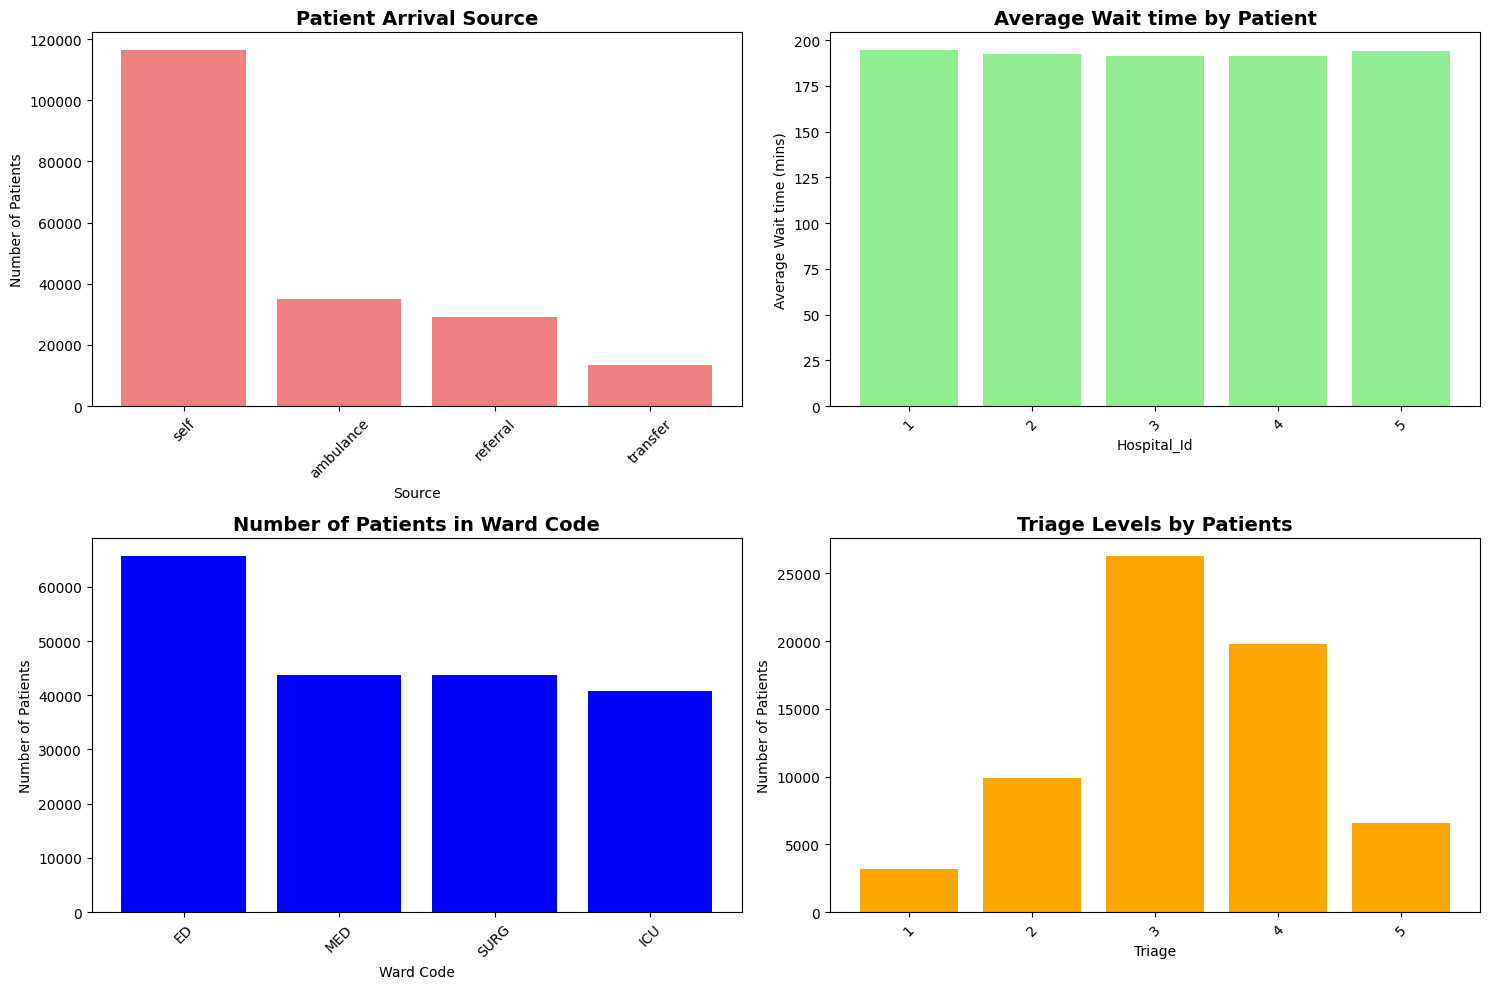

In [19]:
# Cell 4: Regional Store Distribution - Bar Charts
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
arrival_source = admissions['arrival_source'].value_counts()
plt.bar(arrival_source.index, arrival_source.values, color='lightcoral')
plt.title('Patient Arrival Source', fontsize=14, fontweight='bold')
plt.xlabel('Source')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
average_wait = admissions.groupby('hospital_id')['wait_minutes'].mean().sort_values(ascending=False)
plt.bar(average_wait.index, average_wait.values, color='lightgreen')
plt.title('Average Wait time by Patient', fontsize=14, fontweight='bold')
plt.xlabel('Hospital_Id')
plt.ylabel('Average Wait time (mins)')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
ward_code = admissions['ward_code'].value_counts()
plt.bar(ward_code.index, ward_code.values, color='blue')
plt.title('Number of Patients in Ward Code', fontsize=14, fontweight='bold')
plt.xlabel('Ward Code')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)

triage_levels = admissions['triage_level'].value_counts()
plt.bar(triage_levels.index, triage_levels.values, color='orange')
plt.title('Triage Levels by Patients', fontsize=14, fontweight='bold')
plt.xlabel('Triage')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Overview of the Admissions dataset columns

In [20]:

admissions_agg.columns

Index(['date', 'hospital_id', 'ward_code', 'wait_minutes',
       'length_of_stay_days', 'age', 'procedure_flag', 'admission_count',
       'arrival_ambulance', 'arrival_referral', 'arrival_self',
       'arrival_transfer', 'triage_1.0', 'triage_2.0', 'triage_3.0',
       'triage_4.0', 'triage_5.0', 'outcome_death', 'outcome_discharged',
       'outcome_readmit_30d', 'outcome_transferred', 'sex_F', 'sex_M'],
      dtype='object')

In [21]:
admissions_agg['ward_code'].value_counts()

ward_code
ED      5475
MED     5475
SURG    5475
ICU     5473
Name: count, dtype: int64

#### Overview of the Daily Metrics dataset columns

In [22]:
daily_metrics.columns

Index(['date', 'hospital_id', 'ward_code', 'base_beds', 'effective_capacity',
       'occupancy', 'overflow', 'admissions', 'discharges', 'staffing_index',
       'avg_wait_minutes', 'admission_rate_per_bed', 'discharge_rate_per_bed',
       'occupancy_rate'],
      dtype='object')

In [23]:
daily_metrics['ward_code'].value_counts()

ward_code
ED      5475
ICU     5475
MED     5475
SURG    5475
Name: count, dtype: int64

### Merging Admissions with Daily Metrics

I combined the `admissions` and `daily_metrics` DataFrames using a **left join** on shared keys:



In [24]:

merged_df = admissions_agg.merge(daily_metrics, on=['hospital_id', 'date','ward_code'], how='left')

In [25]:
merged_df.head()

,date,hospital_id,ward_code,wait_minutes,length_of_stay_days,age,procedure_flag,admission_count,arrival_ambulance,arrival_referral,arrival_self,arrival_transfer,triage_1.0,triage_2.0,triage_3.0,triage_4.0,triage_5.0,outcome_death,outcome_discharged,outcome_readmit_30d,outcome_transferred,sex_F,sex_M,base_beds,effective_capacity,occupancy,overflow,admissions,discharges,staffing_index,avg_wait_minutes,admission_rate_per_bed,discharge_rate_per_bed,occupancy_rate
0,2022-10-28,1,ED,189.0,0.0,57.0,0,12,4,2,6,0,0.0,2.0,4.0,6.0,0.0,0,8,0,4,4,8,30,34,34,26,51,17,0.999,219,1.700,0.567,1.000
1,2022-10-28,1,ICU,45.0,6.0,53.0,0,8,1,0,6,1,NaN,NaN,NaN,NaN,NaN,0,8,0,0,3,5,20,23,21,1,13,7,1.033,47,0.650,0.350,0.913
2,2022-10-28,1,MED,99.0,4.0,61.0,2,8,2,1,5,0,NaN,NaN,NaN,NaN,NaN,0,8,0,0,3,5,50,58,58,19,50,11,1.009,147,1.000,0.220,1.000
3,2022-10-28,1,SURG,38.0,2.0,61.0,5,8,0,2,5,1,NaN,NaN,NaN,NaN,NaN,0,8,0,0,3,5,40,40,33,0,15,11,0.951,33,0.375,0.275,0.825
4,2022-10-28,2,ED,346.0,0.0,55.0,1,12,2,3,7,0,0.0,1.0,3.0,8.0,0.0,0,12,0,0,6,6,30,34,34,44,71,19,0.964,313,2.367,0.633,1.000


#### Quick view of the Merged DataFrame Columns

In [26]:
merged_df.columns

Index(['date', 'hospital_id', 'ward_code', 'wait_minutes',
       'length_of_stay_days', 'age', 'procedure_flag', 'admission_count',
       'arrival_ambulance', 'arrival_referral', 'arrival_self',
       'arrival_transfer', 'triage_1.0', 'triage_2.0', 'triage_3.0',
       'triage_4.0', 'triage_5.0', 'outcome_death', 'outcome_discharged',
       'outcome_readmit_30d', 'outcome_transferred', 'sex_F', 'sex_M',
       'base_beds', 'effective_capacity', 'occupancy', 'overflow',
       'admissions', 'discharges', 'staffing_index', 'avg_wait_minutes',
       'admission_rate_per_bed', 'discharge_rate_per_bed', 'occupancy_rate'],
      dtype='object')

In [27]:
hospitals.columns

Index(['hospital_id', 'hospital_name', 'city', 'country', 'latitude',
       'longitude', 'founded_year'],
      dtype='object')

### Enriching with Hospital Metadata

I further enhanced `merged_df` by merging it with the `hospitals` DataFrame using a **left join**:



In [28]:
merged_df=merged_df.merge(hospitals, on='hospital_id', how='left')

In [29]:
merged_df.columns

Index(['date', 'hospital_id', 'ward_code', 'wait_minutes',
       'length_of_stay_days', 'age', 'procedure_flag', 'admission_count',
       'arrival_ambulance', 'arrival_referral', 'arrival_self',
       'arrival_transfer', 'triage_1.0', 'triage_2.0', 'triage_3.0',
       'triage_4.0', 'triage_5.0', 'outcome_death', 'outcome_discharged',
       'outcome_readmit_30d', 'outcome_transferred', 'sex_F', 'sex_M',
       'base_beds', 'effective_capacity', 'occupancy', 'overflow',
       'admissions', 'discharges', 'staffing_index', 'avg_wait_minutes',
       'admission_rate_per_bed', 'discharge_rate_per_bed', 'occupancy_rate',
       'hospital_name', 'city', 'country', 'latitude', 'longitude',
       'founded_year'],
      dtype='object')

### Quickview of the Wards Dataset Columns

In [30]:
wards.columns

Index(['hospital_id', 'ward_id', 'ward_code', 'ward_name', 'base_beds'], dtype='object')

### 🛏️ Merging Ward-Level Details

I enriched `merged_df` by merging it with the `wards` DataFrame using a **left join** on multiple keys:


In [31]:
merged_df = merged_df.merge(wards, on=['hospital_id','ward_code', 'base_beds'], how ='left')

In [32]:
merged_df.columns

Index(['date', 'hospital_id', 'ward_code', 'wait_minutes',
       'length_of_stay_days', 'age', 'procedure_flag', 'admission_count',
       'arrival_ambulance', 'arrival_referral', 'arrival_self',
       'arrival_transfer', 'triage_1.0', 'triage_2.0', 'triage_3.0',
       'triage_4.0', 'triage_5.0', 'outcome_death', 'outcome_discharged',
       'outcome_readmit_30d', 'outcome_transferred', 'sex_F', 'sex_M',
       'base_beds', 'effective_capacity', 'occupancy', 'overflow',
       'admissions', 'discharges', 'staffing_index', 'avg_wait_minutes',
       'admission_rate_per_bed', 'discharge_rate_per_bed', 'occupancy_rate',
       'hospital_name', 'city', 'country', 'latitude', 'longitude',
       'founded_year', 'ward_id', 'ward_name'],
      dtype='object')

In [33]:
eda_stage_1(merged_df, name='merged_df')

merged_df dataframe information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21898 entries, 0 to 21897
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    21898 non-null  object 
 1   hospital_id             21898 non-null  int64  
 2   ward_code               21898 non-null  object 
 3   wait_minutes            21898 non-null  float64
 4   length_of_stay_days     21898 non-null  float64
 5   age                     21898 non-null  float64
 6   procedure_flag          21898 non-null  int64  
 7   admission_count         21898 non-null  int64  
 8   arrival_ambulance       21898 non-null  int64  
 9   arrival_referral        21898 non-null  int64  
 10  arrival_self            21898 non-null  int64  
 11  arrival_transfer        21898 non-null  int64  
 12  triage_1.0              5475 non-null   float64
 13  triage_2.0              5475 non-null   float64
 14  triage

In [34]:
merged_df['date'] = pd.to_datetime(merged_df['date'])

In [35]:
merged_df['month'] = merged_df['date'].dt.to_period('M').dt.to_timestamp()

In [37]:
eda_stage_1(merged_df, name='merged_df')

merged_df dataframe information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21898 entries, 0 to 21897
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    21898 non-null  datetime64[ns]
 1   hospital_id             21898 non-null  int64         
 2   ward_code               21898 non-null  object        
 3   wait_minutes            21898 non-null  float64       
 4   length_of_stay_days     21898 non-null  float64       
 5   age                     21898 non-null  float64       
 6   procedure_flag          21898 non-null  int64         
 7   admission_count         21898 non-null  int64         
 8   arrival_ambulance       21898 non-null  int64         
 9   arrival_referral        21898 non-null  int64         
 10  arrival_self            21898 non-null  int64         
 11  arrival_transfer        21898 non-null  int64         
 12  triage_1.0    

### Hospital and Ward Performance Analysis
#### Utilization and Capacity
##### distribution of occupancy_rate and overflow by ward_name.



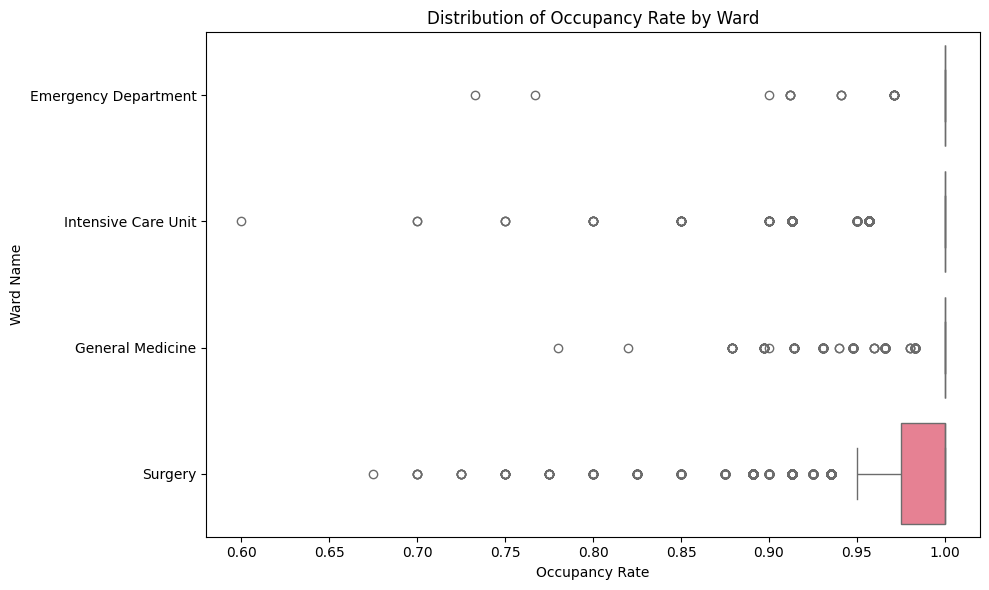

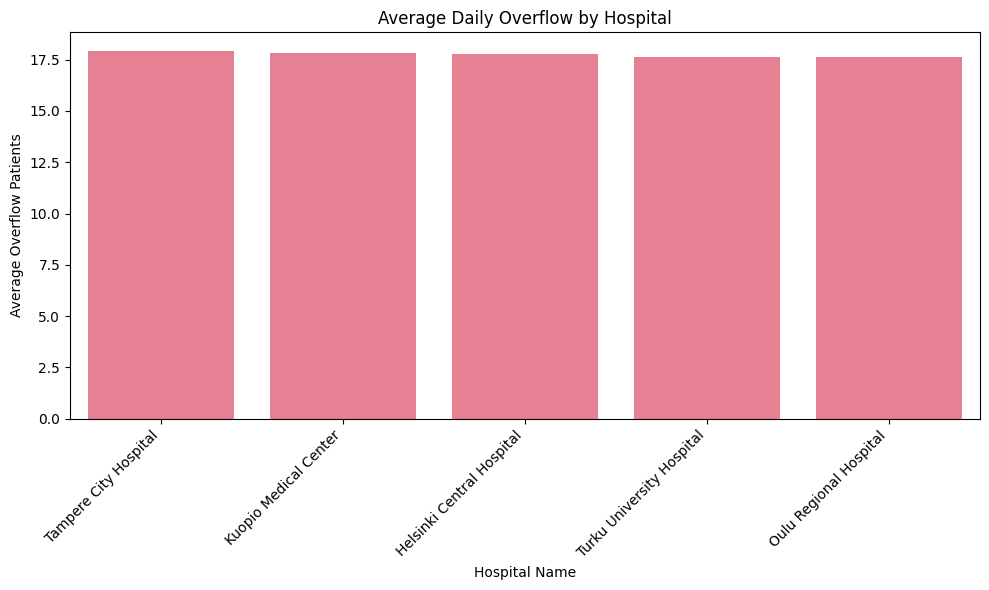

In [38]:
## Occupancy Rate Distribution by Ward
plt.figure(figsize=(10, 6))
sns.boxplot(x='occupancy_rate', y='ward_name', data=merged_df)
plt.title('Distribution of Occupancy Rate by Ward')
plt.xlabel('Occupancy Rate')
plt.ylabel('Ward Name')
plt.tight_layout()
plt.show()

## Average Overflow by Hospital
overflow_summary = merged_df.groupby('hospital_name')['overflow'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=overflow_summary.index, y=overflow_summary.values)
plt.title('Average Daily Overflow by Hospital')
plt.ylabel('Average Overflow Patients')
plt.xlabel('Hospital Name')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Admissions vs. Discharges (Time Series)

In [39]:
merged_df['week'] = merged_df['date'].dt.to_period('W')

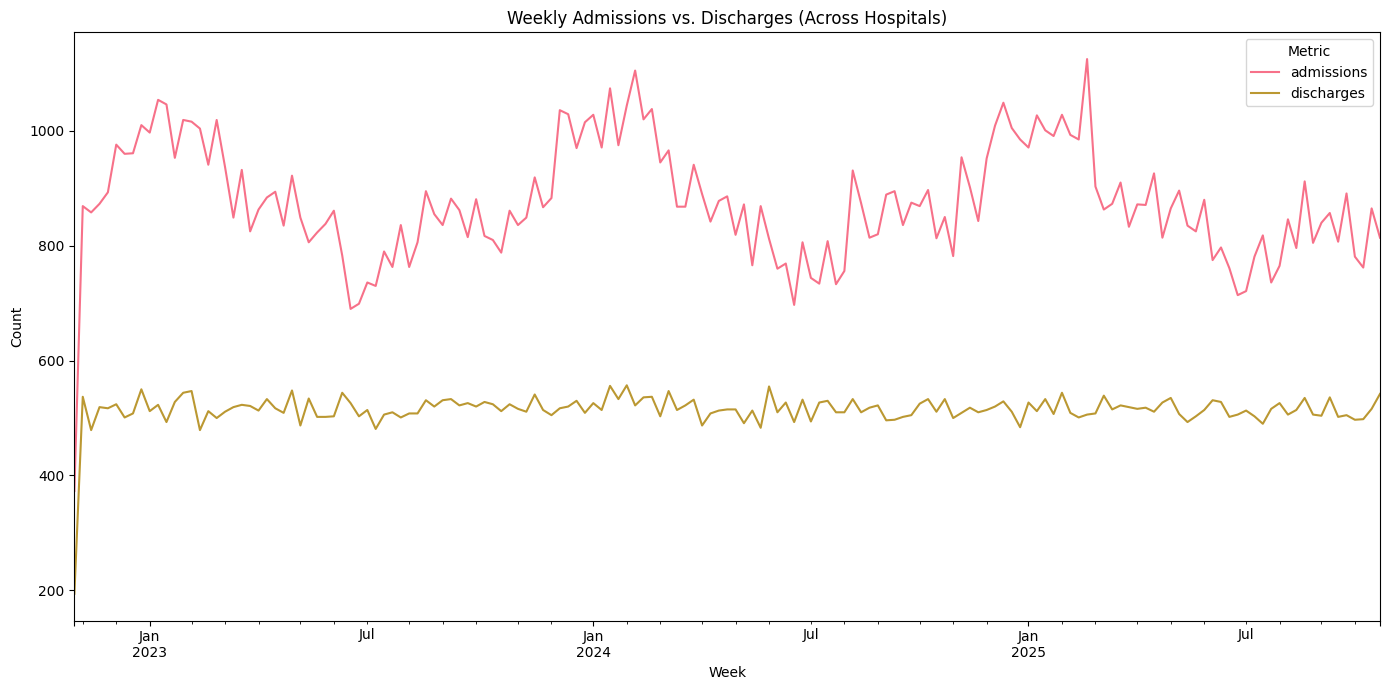

In [40]:
## Weekly Admissions vs. Discharges for a Sample Hospital
hospital_1 = merged_df[merged_df['hospital_id'] == 1].copy()
merged_df['week'] = merged_df['date'].dt.to_period('W')

# Aggregate by week
weekly_flow = hospital_1.groupby('week')[['admissions', 'discharges']].sum()
weekly_flow['net_change'] = weekly_flow['admissions'] - weekly_flow['discharges']

# Plotting the time series
plt.figure(figsize=(14, 7))
weekly_flow[['admissions', 'discharges']].plot(kind='line', ax=plt.gca())
plt.title('Weekly Admissions vs. Discharges (Across Hospitals)')
plt.xlabel('Week')
plt.ylabel('Count')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

### Arrival Source Impact

In [41]:
## Average Wait Minutes by Arrival Source
arrival_source = arrival_source['arrival_ambulance','arrival_referral', 'arrival_self','arrival_transfer']
wait_by_source = merged_df.groupby('arrival_source')['wait_minutes'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=wait_by_source.index, y=wait_by_source.values,hue=wait_by_source,legend=False palette='Blues_d')
plt.title('Average Wait Time by Patient Arrival Source')
plt.xlabel('Arrival Source')
plt.ylabel('Average Wait Minutes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (4060458724.py, line 6)

### Outcome by Demograhy (Age)

In [ ]:
## Outcome Distribution by Age Group
# Create age bins
bins = [0, 18, 45, 65, 100]
labels = ['0-17', '18-44', '45-64', '65+']
merged_df['age_group'] = pd.cut(merged_df['age'], bins=bins, labels=labels, right=False)

# Normalize the counts within each age group
outcome_age_counts = merged_df.groupby(['age_group', 'outcome']).size().unstack(fill_value=0)
outcome_age_prop = outcome_age_counts.apply(lambda x: x / x.sum(), axis=1)

# Plotting the stacked bar chart
outcome_age_prop.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Admission Outcome Proportion by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Outcome')
plt.tight_layout()
plt.show()

KeyError: 'outcome'

### Average wait time by City

C:\Users\ASUS PC\AppData\Local\Temp\ipykernel_22012\4053643621.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=wait_by_city.index, y=wait_by_city.values, palette='viridis')


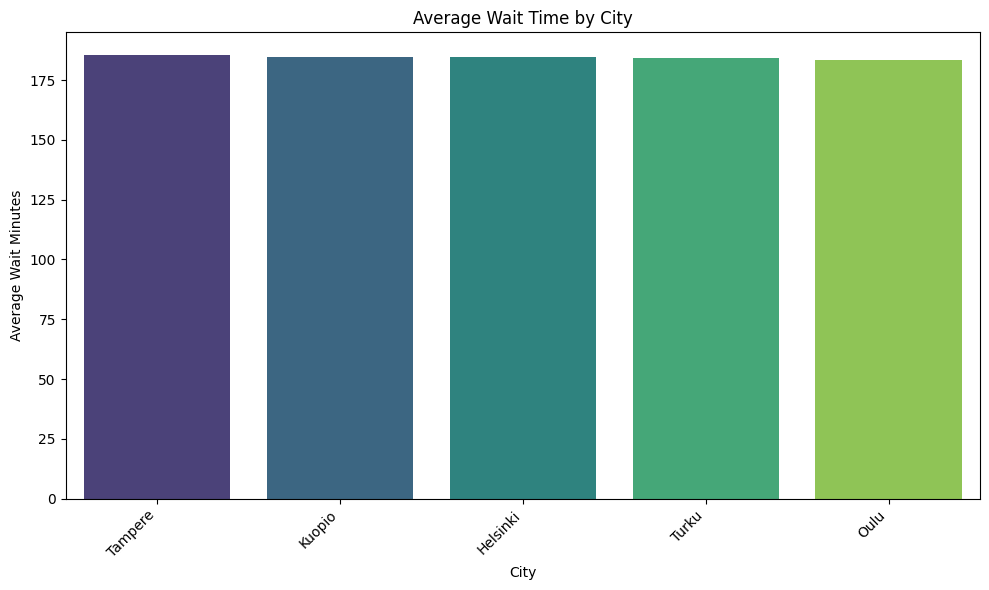

In [42]:
## Average Wait Minutes by City
wait_by_city = merged_df.groupby('city')['avg_wait_minutes'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=wait_by_city.index, y=wait_by_city.values, palette='viridis')
plt.title('Average Wait Time by City')
plt.xlabel('City')
plt.ylabel('Average Wait Minutes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



### Visualisation of Average Weekly Admission trend

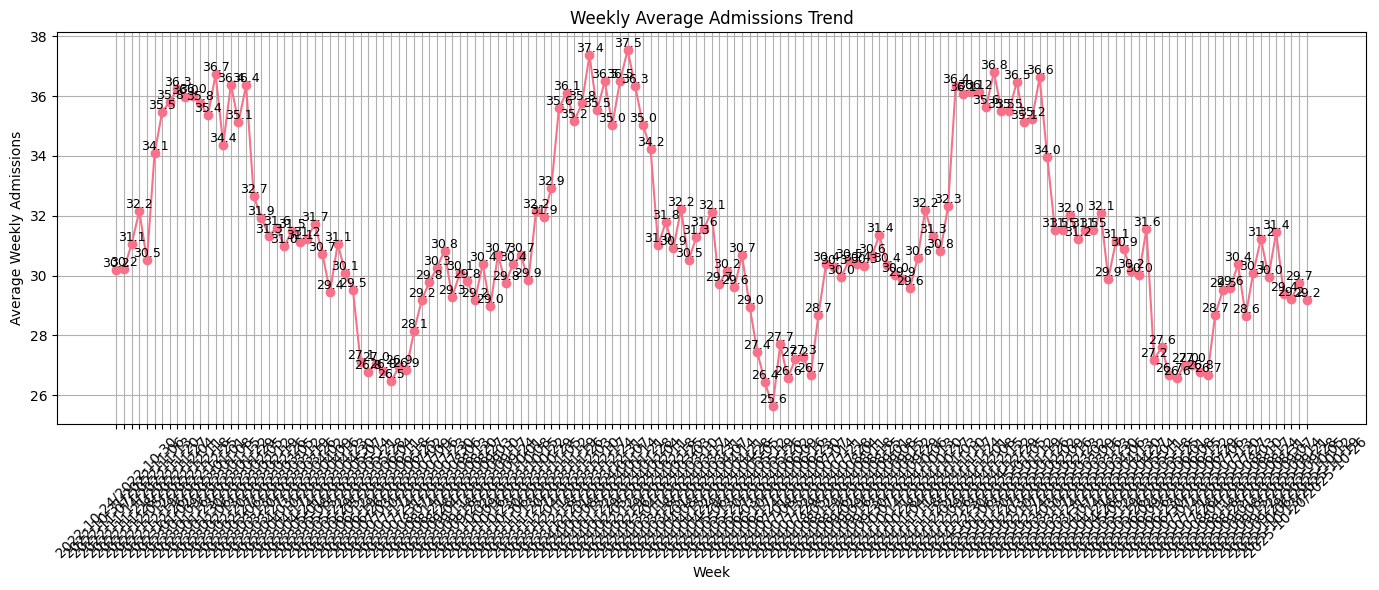

In [43]:
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['week'] = merged_df['date'].dt.to_period('W')


weekly_admissions = merged_df.groupby('week')['admissions'].mean().reset_index()
weekly_admissions['week'] = weekly_admissions['week'].astype(str)

plt.figure(figsize=(14, 6))
plt.plot(weekly_admissions['week'], weekly_admissions['admissions'], marker='o', linestyle='-')

for i in range(len(weekly_admissions)):
    plt.text(
        x=weekly_admissions['week'][i],
        y=weekly_admissions['admissions'][i],
        s=f"{weekly_admissions['admissions'][i]:.1f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.xticks(rotation=45)
plt.title('Weekly Average Admissions Trend')
plt.xlabel('Week')
plt.ylabel('Average Weekly Admissions')
plt.grid(True)
plt.tight_layout()
plt.show()



### Visualisation of Average Monthly Admission Trend

In [44]:
merged_df['date'] = pd.to_datetime(merged_df['date'])



In [45]:
merged_df['month'] = merged_df['date'].dt.to_period('M')


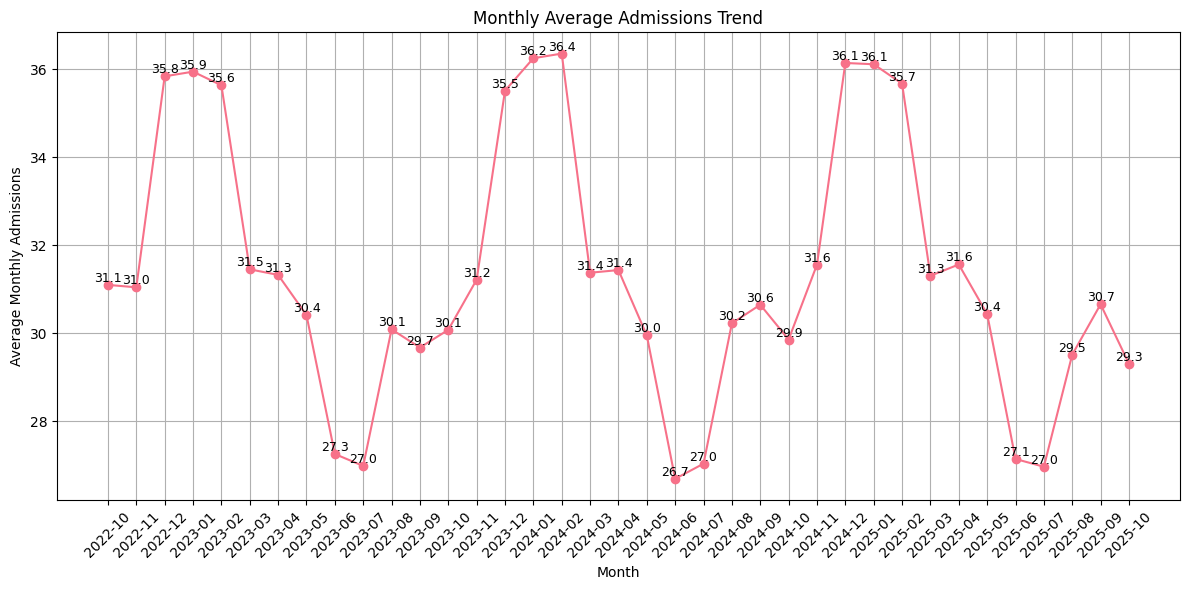

In [46]:
monthly_admissions = merged_df.groupby('month')['admissions'].mean().reset_index()
monthly_admissions['month'] = monthly_admissions['month'].astype(str)

plt.figure(figsize=(12, 6))
plt.plot(monthly_admissions['month'], monthly_admissions['admissions'], marker='o', linestyle='-')

# Add labels at each point
for i in range(len(monthly_admissions)):
    plt.text(
        x=monthly_admissions['month'][i],
        y=monthly_admissions['admissions'][i],
        s=f"{monthly_admissions['admissions'][i]:.1f}",  # rounded to 1 decimal
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.xticks(rotation=45)
plt.title('Monthly Average Admissions Trend')
plt.xlabel('Month')
plt.ylabel('Average Monthly Admissions')
plt.grid(True)
plt.tight_layout()
plt.show()

## *Feature Engineering*

#### Engineer new features from the admissions dataset that will help with the predictions.
- Avoid data leakage i.e Only use information that would be known at prediction time 

### Separating Numeric and Categorical Columns

identifying and separating numeric and non-numeric (categorical) columns from `merged_df` for targeted analysis:



In [55]:
num_cols = merged_df.select_dtypes(include=[np.number]).columns.to_list()
cat_cols = merged_df.select_dtypes(exclude=[np.number]).columns.to_list()

### 📈 Visualizing Correlations Among Numeric Features

compute and plot the correlation matrix for all numeric columns in `merged_df` to identify linear relationships:


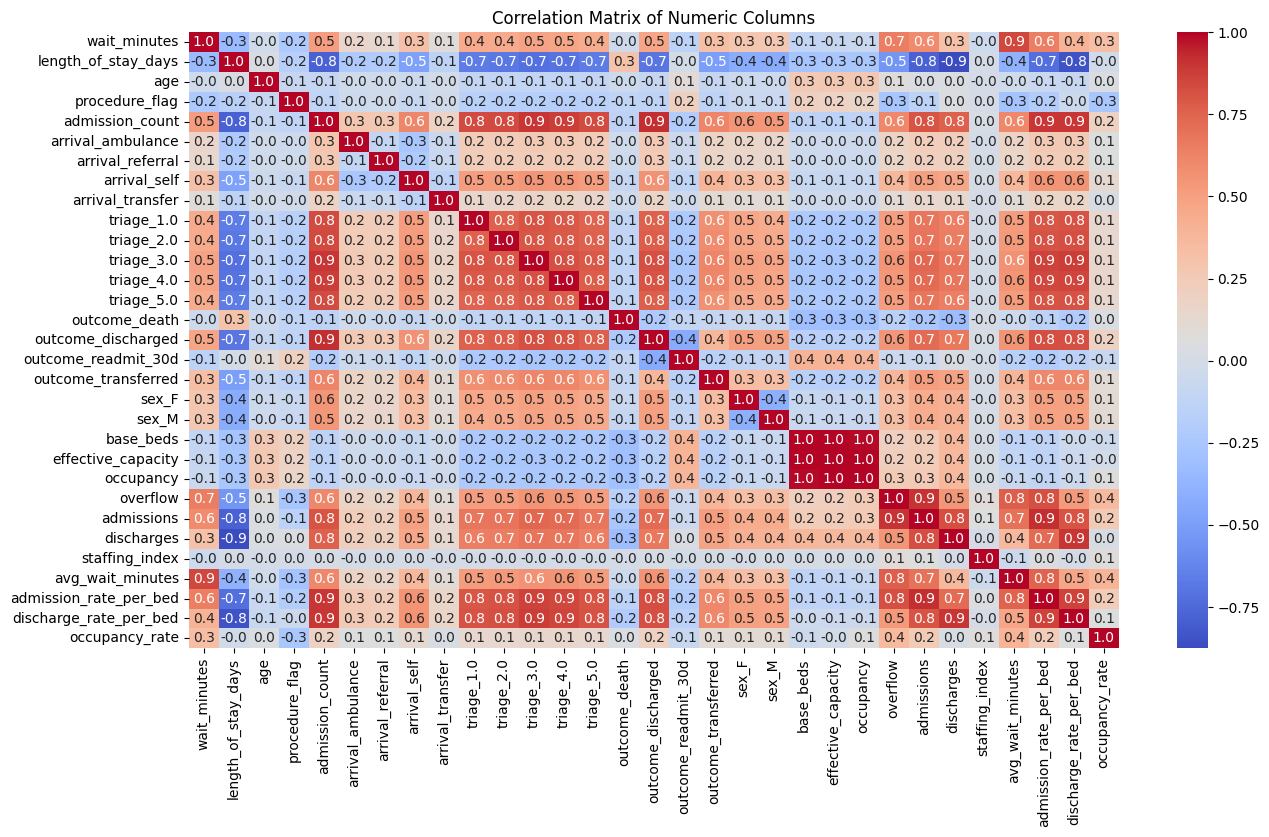

In [60]:
cols_to_drop = ['hospital_id','latitude', 'longitude', 'founded_year']
for col in cols_to_drop:
    if col in num_cols:
        num_cols.remove(col, inplace=True)
    


correlation_matrix = merged_df[num_cols].corr()
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title("Correlation Matrix of Numeric Columns")
plt.show()



In [ ]:
admissions['triage_level'] = pd.to_numeric(admissions['triage_level'], errors='coerce')
admissions['wait_per_triage'] = admissions['wait_minutes'] / admissions['triage_level']

admissions['wait_per_triage'] = admissions['wait_per_triage'].clip(lower=0, upper=admissions['wait_per_triage'].quantile(0.95))
admissions['wait_per_triage'] = admissions['wait_per_triage'].fillna(admissions['wait_per_triage'].median())

admissions['bed_impact_score'] = (
    admissions['length_of_stay_days'] * 
    (1 + admissions['procedure_flag']) *
    (6 - pd.to_numeric(admissions['triage_level'], errors='coerce'))
)


admissions.drop(columns=['triage_level', 'wait_minutes', 'length_of_stay_days', 'procedure_flag'], inplace=True)

In [69]:
admissions_agg = admissions.groupby(['date', 'hospital_id', 'ward_code']).agg({
    'wait_per_triage': 'mean',
    'age': 'mean',
    'bed_impact_score': 'mean'
}).reset_index()

categorical_cols = ['arrival_source', 'outcome', 'sex']

for col in categorical_cols:
    counts = (admissions.groupby(['date', 'hospital_id', 'ward_code', col])
              .size()
              .unstack(fill_value=0))
    counts.columns = [f'{col}_{c}' for c in counts.columns]
    admissions_agg = admissions_agg.merge(counts.reset_index(), 
                                          on=['date', 'hospital_id', 'ward_code'], 
                                          how='left')

admissions_agg.head(10)

,date,hospital_id,ward_code,wait_per_triage,age,bed_impact_score,arrival_source_ambulance,arrival_source_referral,arrival_source_self,arrival_source_transfer,outcome_death,outcome_discharged,outcome_readmit_30d,outcome_transferred,sex_F,sex_M
0,2022-10-28,1,ED,60.375000,56.833333,0.0,4,2,6,0,0,8,0,4,4,8
1,2022-10-28,1,ICU,75.000000,53.250000,NaN,1,0,6,1,0,8,0,0,3,5
2,2022-10-28,1,MED,75.000000,60.625000,NaN,2,1,5,0,0,8,0,0,3,5
3,2022-10-28,1,SURG,75.000000,61.000000,NaN,0,2,5,1,0,8,0,0,3,5
4,2022-10-28,2,ED,100.916667,55.333333,0.0,2,3,7,0,0,12,0,0,6,6
5,2022-10-28,2,ICU,75.000000,40.000000,NaN,1,2,3,1,0,7,0,0,4,3
6,2022-10-28,2,MED,75.000000,48.625000,NaN,2,1,5,0,0,8,0,0,4,4
7,2022-10-28,2,SURG,75.000000,56.125000,NaN,1,1,6,0,0,8,0,0,5,3
8,2022-10-28,3,ED,41.847222,53.833333,0.0,1,2,8,1,0,10,0,2,7,5
9,2022-10-28,3,ICU,75.000000,45.250000,NaN,0,0,5,3,0,8,0,0,5,3


### Preventing Data Leakage
Why Lag Features? To predict today's admissions, we can only use information from yesterday or earlier.

Lag Strategy:

- 1-day lag: Yesterday's metrics (recent trend)
- 7-day lag: Last week's metrics (weekly pattern)

In [73]:
metrics = daily_metrics.sort_values(['hospital_id', 'ward_code', 'date'])

lag_columns = ['occupancy', 'overflow', 'discharges', 'admission_rate_per_bed',
               'avg_wait_minutes', 'occupancy_rate']

for col in lag_columns:
    metrics[f'{col}_lag1'] = metrics.groupby(['hospital_id', 'ward_code'])[col].shift(1)
    metrics[f'{col}_lag7'] = metrics.groupby(['hospital_id', 'ward_code'])[col].shift(7)
    

metrics_safe = metrics.drop(columns=lag_columns)
metrics = metrics_safe.dropna()

In [74]:
main_data = pd.merge(admissions_agg, metrics, on=['date', 'hospital_id', 'ward_code'], how='inner')

In [77]:
main_data.to_csv(r'C:\Users\ASUS PC\Desktop\AMDARI INTERNSHIP\Med_Optix\Optix_repo\Model\cleanned_df.csv', index=False)

In [ ]:

merged_df.to_csv(r'C:\Users\ASUS PC\Desktop\AMDARI INTERNSHIP\Med_Optix\Optix_repo\Model\clened_df.csv', index=False)

